# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import warnings
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import yaml
from torchtnt.utils.flops import FlopTensorDispatchMode
from tqdm import tqdm

from assembly import Assembly
from utils import load_yaml, num_params, num_trainable_params

W0620 09:14:55.679000 72786 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [3]:
sns.set(font_scale=1.25, style="whitegrid")

# Ignore known warnings that come when constructing subnets.
warnings.filterwarnings("ignore", message=".*The parameter 'pretrained' is deprecated.*")
warnings.filterwarnings("ignore", message=".*Arguments other than a weight enum.*")
warnings.filterwarnings("ignore", message=".*already erased node.*")

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Using device = {device}")

NUM_CORES = os.cpu_count()
if hasattr(os, "sched_getaffinity"):
    # This function is only available on certain platforms. When running with Slurm, it can tell us the true
    # number of cores we have access to.
    NUM_CORES = len(os.sched_getaffinity(0))
print (f"Using {NUM_CORES} cores.")

Using 8 cores.


# Scan Files

Find all result files. Combine into a single dataframe.

In [4]:
project_name = "across-scales"
calc_sizes = True
force_recalc = False
proj_dir = Path("../experiments") / project_name
seed_pattern = re.compile(r"result-(\d+)\.pkl")

cached_metas = {}
metas = []
results = []
for resfile in tqdm(list(sorted(proj_dir.rglob("result*.pkl")))):
    if not resfile.is_file():
        print(f"WARNING: Not a file: {resfile}")

    if resfile.parent not in cached_metas:
        metafile = resfile.parent / "metadata.yml"
        meta = load_yaml(metafile)
        if not meta:
            print(f"WARNING: Meta file is empty: {metafile}")
            continue
        cached_metas[resfile.parent] = meta
        if calc_sizes and (force_recalc or ("num_params" not in meta) or ("num_flops" not in meta)):
            cfg = load_yaml(resfile.parent / "config.yml")
            model = Assembly(cfg["assembly"], cfg.get("head"), input_shape=[3, 224, 224])
            meta["num_params"] = num_params(model)
            meta["num_trainable_params"] = num_trainable_params(model)
            with FlopTensorDispatchMode(model) as ftdm:
                dummy_img = torch.randn(1, 3, 224, 224)
                _ = model(dummy_img)
                meta["num_flops"] = sum(ftdm.flop_counts[""].values())
            # Write data back out to meta so we don't have to calc again.
            with open(metafile, "w") as f:
                yaml.dump(meta, f)

    meta = cached_metas[resfile.parent].copy()  # Important to copy so we don't write to the original.
    metas.append(meta)
    try:
        meta["seed"] = int(seed_pattern.match(resfile.name).group(1))
    except AttributeError:
        print("Unable to parse seed:", resfile)
        raise
    results.append(pd.read_pickle(resfile))

100%|██████████| 701/701 [24:21<00:00,  2.08s/it]


In [5]:
print(metas[0])
results[0]

{'adapter': 'block_with_downsample', 'arch': 'mobilenet-v3', 'first_deleted_block': 1, 'last_deleted_block': 1, 'num_downsamples': 0, 'num_params': 5489056, 'num_trainable_params': 10464, 'num_flops': 236233664, 'seed': 12345}


,Epoch,Step,Time/Data,LR,Loss,Time/Img Per Sec,Max Mem,Accuracy,Time/Step,Overall/Train Loss,Overall/Train Accuracy,Overall/Test Accuracy,Time/Total,Time/Per Epoch
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2503,1,2503,0.000319,0.002000,1.546190,94.425249,4877.767090,0.722222,0.762827,1.999528,0.601748,0.71600,2769.267798,2769.268777
5006,2,5006,0.000123,0.001951,1.286014,770.034673,1994.129395,0.722222,0.093625,1.566028,0.670622,0.73374,5540.621554,2771.351638
7509,3,7509,0.000139,0.001809,1.445410,776.056289,1994.129395,0.694444,0.092915,1.469275,0.687217,0.73688,8289.042596,2748.419793
10012,4,10012,0.000170,0.001588,1.483688,780.507057,1994.129395,0.680556,0.092417,1.433174,0.693317,0.73814,11026.609425,2737.565727
12515,5,12515,0.000176,0.001309,1.466748,696.138808,1994.129395,0.680556,0.103603,1.413563,0.697019,0.73764,13759.668759,2733.058148
15018,6,15018,0.000141,0.001000,1.613015,781.531148,1994.129395,0.625000,0.092267,1.400717,0.698629,0.74170,16519.975104,2760.304254
17521,7,17521,0.000129,0.000691,1.545636,767.170818,1994.129395,0.694444,0.093979,1.392076,0.699940,0.74166,19271.284213,2751.306827
20024,8,20024,0.000170,0.000412,1.214846,781.296603,1994.129395,0.777778,0.092324,1.381047,0.701856,0.74300,22033.869341,2762.583565
22527,9,22527,0.000145,0.000191,1.832417,780.140089,1994.129395,0.652778,0.092435,1.379921,0.702325,0.74208,24772.456062,2738.585562


In [6]:
full_df = pd.concat(results, keys=[tuple(m.values()) for m in metas], names=list(metas[0].keys()) + ["Step"])
full_df.set_index("Epoch", append=True, inplace=True)
full_df

Step  \
adapter               arch                     first_deleted_block last_deleted_block num_downsamples num_params num_trainable_params num_flops  seed  Step  Epoch          
block_with_downsample mobilenet-v3             1                   1                  0               5489056    10464                236233664  12345 0     0          0   
                                                                                                                                                       2503  1       2503   
                                                                                                                                                       5006  2       5006   
                                                                                                                                                       7509  3       7509   
                                                                                                                                                       10012 4      10012   
...                                                                                                                                                                   ...   
finetune              swin-t-lr-2.0e-4-wd-0.01 5                   6                  1               17629402   17629402             2365412352 12345 15018 6      15018   
                                                                                                                                                       17521 7      17521   
                                                                                                                                                       20024 8      20024   
                                                                                                                                                       22527 9      22527   
                                                                                                                                                       25030 10     25030   

                                                                                                                                                                    Time/Data  \
adapter               arch                     first_deleted_block last_deleted_block num_downsamples num_params num_trainable_params num_flops  seed  Step  Epoch              
block_with_downsample mobilenet-v3             1                   1                  0               5489056    10464                236233664  12345 0     0            NaN   
                                                                                                                                                       2503  1       0.000319   
                                                                                                                                                       5006  2       0.000123   
                                                                                                                                                       7509  3       0.000139   
                                                                                                                                                       10012 4       0.000170   
...                                                                                                                                                                       ...   
finetune              swin-t-lr-2.0e-4-wd-0.01 5                   6                  1               17629402   17629402             2365412352 12345 15018 6       0.000335   
                                                                                                                                                       17521 7       0.000115   
                                                                                                                                                 

In [7]:
# NOTE: This only works since all runs were done for the exact same number of epochs.
#       Otherwise, we'd need to do a groupby and filter each group to its own max epoch.
final_df = full_df.loc[full_df.index.get_level_values("Epoch") == full_df.index.get_level_values("Epoch").max()]

In [8]:
print("Available architectures:")
for archname in sorted(final_df.index.get_level_values("arch").unique()):
    print(f"    {archname}")

Available architectures:
    mobilenet-v3
    resnet-50
    resnet-50-lr-1.0e-2
    resnet-50-lr-2.0e-4
    resnet-50-swin-t
    resnet-50-wd-0.01
    resnet-50-wd-0.3
    swin-t
    swin-t-bs-1024
    swin-t-lr-1.0e-2
    swin-t-lr-2.0e-4
    swin-t-lr-2.0e-4-wd-0.01


# Plots

In [23]:
STAGES = {
    # Stage name to subnet part number.
    "Stage 1": 1,
    "Stage 2": 3,
    "Stage 3": 5,
}
STAGE_NAMES = {
    # Subnet part number to stage name.
    1: "Stage 1",
    3: "Stage 2",
    5: "Stage 3",
}
DFLT_ARCHS = [
    "resnet-50",
    "swin-t",
    "mobilenet-v3",
    "resnet-50-swin-t",
]
DFLT_ADAPTERS = [
    "finetune",
    "linear_no_downsample",
    "linear_relu_no_downsample",
    "linear_post_downsample",
    "bottleneck_no_downsample",
    # "block_no_downsample",
    "downsample_then_linear",
    "downsample_then_linear_relu",
    "downsample_then_3x3conv",
    "downsample_then_bottleneck",
    # "downsample_then_block",
    "conv3x3_with_downsample",
    "bottleneck_with_downsample",
    # "block_with_downsample",
]
ALL_ADAPTERS = [
    "finetune",
    "linear_no_downsample",
    "linear_relu_no_downsample",
    "linear_post_downsample",
    "bottleneck_no_downsample",
    "block_no_downsample",
    "downsample_then_linear",
    "downsample_then_linear_relu",
    "downsample_then_3x3conv",
    "downsample_then_bottleneck",
    "downsample_then_block",
    "conv3x3_with_downsample",
    "bottleneck_with_downsample",
    "block_with_downsample",
]

def savefig(figname):
    # plt.tight_layout()  # Does not play nicely with Seaborn's FacetGrid.
    save_dir = proj_dir / "figures"
    save_dir.mkdir(parents=True, exist_ok=True)
    print(f"Saving plot: {save_dir}/{figname}.(pdf/png)")
    plt.savefig(save_dir / (figname + ".pdf"))
    plt.savefig(save_dir / (figname + ".png"))


def plot_accuracy(final_acc_df, start_block=1, arch_choice=None, adapter_choice=None, name=None, save=True, **kwargs):
    final_acc_df = final_acc_df.loc[final_acc_df.index.get_level_values("first_deleted_block") == start_block]
    if not arch_choice:
        arch_choice = DFLT_ARCHS
    elif isinstance(arch_choice, str):
        arch_choice = [arch_choice]
    if not adapter_choice:
        adapter_choice = DFLT_ADAPTERS
    elif isinstance(adapter_choice, str):
        adapter_choice = [adapter_choice]

    # Either filter down to one value, or tell Seaborn to plot them as hue/style.
    title = []
    if name:
        title.append(name)
    if len(arch_choice) == 1:
        final_acc_df = final_acc_df.loc[final_acc_df.index.get_level_values("arch") == arch_choice[0]]
        title.append(arch_choice[0])
    elif "arch" in final_acc_df.index.names:
        kwargs.setdefault("style", "arch")
        kwargs.setdefault("style_order", arch_choice)
    title.append(STAGE_NAMES[start_block])
    if len(adapter_choice) == 1:
        final_acc_df = final_acc_df.loc[final_acc_df.index.get_level_values("adapter") == adapter_choice[0]]
        title.append(adapter_choice[0])
    elif "adapter" in final_acc_df.index.names:
        kwargs.setdefault("hue", "adapter")
        kwargs.setdefault("hue_order", adapter_choice)
    title = " ".join(title)

    # Automatically prefer these palettes for a certain number of hue categories.
    huecol = (final_acc_df.index.get_level_values(kwargs["hue"]) if kwargs["hue"] in final_acc_df.index.names
              else final_acc_df[kwargs["hue"]])
    num_hues = len(huecol.unique())
    if num_hues > 20:
        kwargs.setdefault("palette", "magma")
    elif num_hues > 10:
        kwargs.setdefault("palette", "tab20")

    # Try to intelligently select which kind based on the x-axis type.
    if "x" not in kwargs:
        kwargs["x"] = "last_deleted_block"
    if kwargs["x"] == "last_deleted_block" or kwargs["x"] == "num_downsamples":
        kwargs.setdefault("kind", "line")
        xvar = "depth"
    elif kwargs["x"] == "num_params" or kwargs["x"] == "num_trainable_params":
        kwargs.setdefault("kind", "scatter")
        xvar = "size"
    elif kwargs["x"] == "num_flops" or kwargs["x"] == "flops":
        kwargs.setdefault("kind", "scatter")
        xvar = "flops"
    else:
        xvar = kwargs["x"]

    # Insert some other styling recommendations.
    if kwargs.get("kind") == "line":
        # Add markers to lines (if not already configured).
        kwargs.setdefault("marker", "o")
        kwargs.setdefault("markersize", 7)
        kwargs.setdefault("errorbar", "sd")
    kwargs.setdefault("facet_kws", {}).setdefault("legend_out", True)

    ax = sns.relplot(final_acc_df, y="Overall/Test Accuracy", **kwargs).ax
    ax.set_title(title)
    if save:
        savefig(f"{title.replace(' ', '-')}-acc-vs-{xvar}".lower())
        return ax


def plot_accuracy_vs_depth(final_acc_df, **kwargs):
    return plot_accuracy(final_acc_df, x="last_deleted_block", **kwargs)


def plot_accuracy_vs_size(final_acc_df, **kwargs):
    if "num_params" not in final_acc_df.index.names:
        return None
    return plot_accuracy(final_acc_df, x="num_params", **kwargs)


def plot_accuracy_vs_flops(final_acc_df, **kwargs):
    if "num_flops" not in final_acc_df.index.names:
        return None
    return plot_accuracy(final_acc_df, x="num_flops", **kwargs)

In [10]:
current_src_stage = STAGES["Stage 1"]

Saving plot: ../experiments/across-scales/figures/resnet-50-stage-1-acc-vs-depth.(pdf/png)


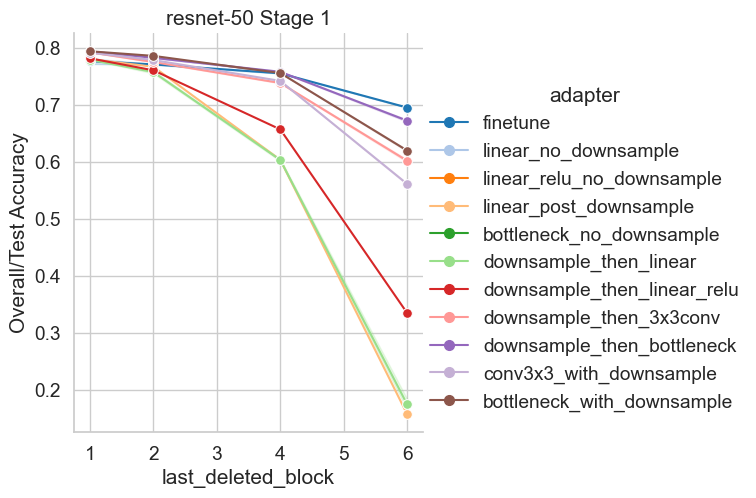

In [24]:
_ = plot_accuracy_vs_depth(final_df, start_block=current_src_stage, arch_choice="resnet-50")

Saving plot: ../experiments/across-scales/figures/resnet-50-stage-1-acc-vs-size.(pdf/png)


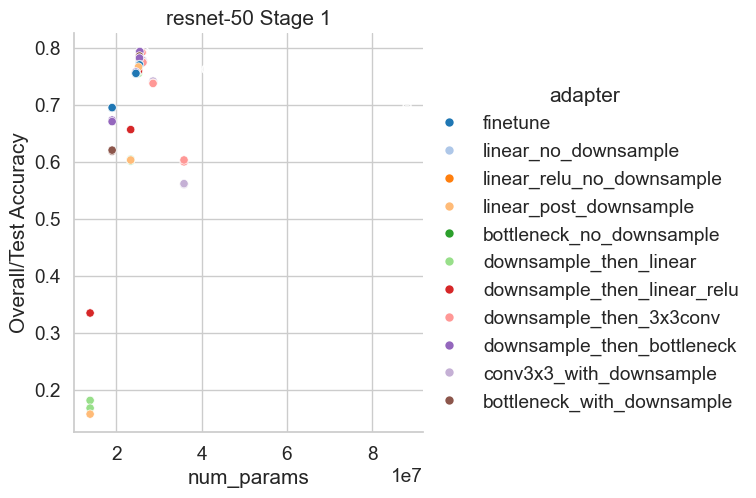

In [25]:
_ = plot_accuracy_vs_size(final_df, start_block=current_src_stage, arch_choice="resnet-50")

Saving plot: ../experiments/across-scales/figures/resnet-50-stage-1-acc-vs-flops.(pdf/png)


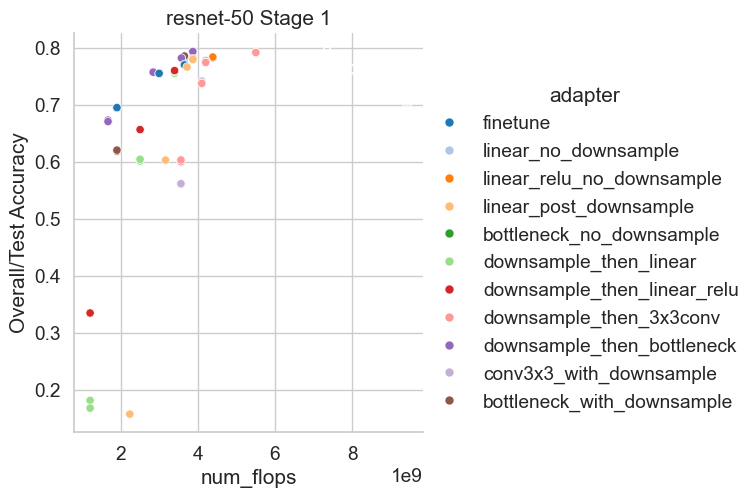

In [26]:
_ = plot_accuracy_vs_flops(final_df, start_block=current_src_stage, arch_choice="resnet-50")

Saving plot: ../experiments/across-scales/figures/swin-t-stage-1-acc-vs-depth.(pdf/png)


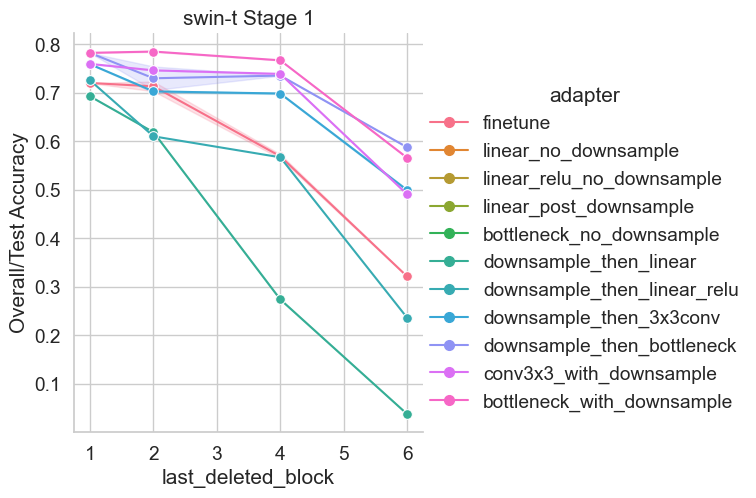

In [27]:
_ = plot_accuracy_vs_depth(final_df, start_block=current_src_stage, arch_choice="swin-t")

Saving plot: ../experiments/across-scales/figures/swin-t-stage-1-acc-vs-size.(pdf/png)


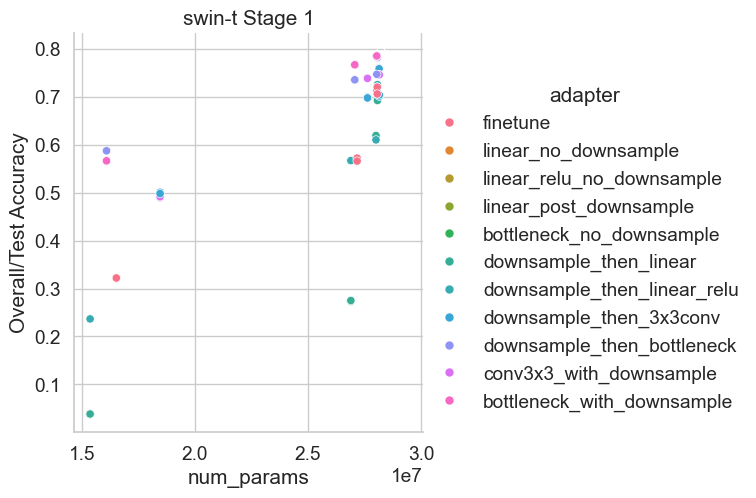

In [28]:
_ = plot_accuracy_vs_size(final_df, start_block=current_src_stage, arch_choice="swin-t")

Saving plot: ../experiments/across-scales/figures/swin-t-stage-1-acc-vs-flops.(pdf/png)


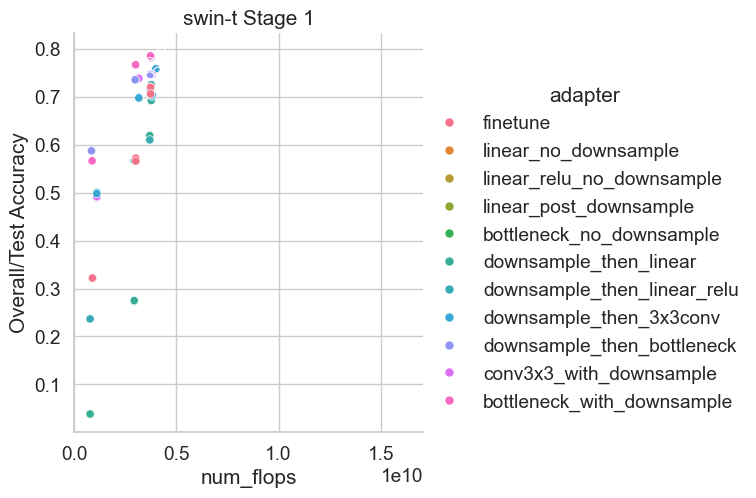

In [29]:
_ = plot_accuracy_vs_flops(final_df, start_block=current_src_stage, arch_choice="swin-t")

Saving plot: ../experiments/across-scales/figures/mobilenet-v3-stage-1-acc-vs-depth.(pdf/png)


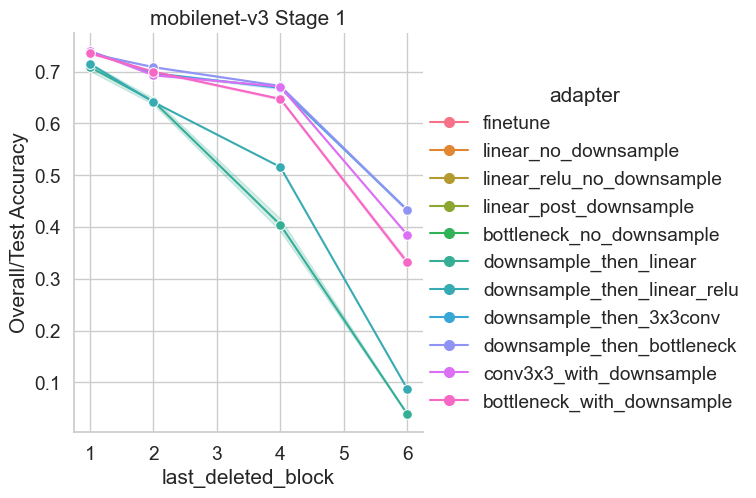

In [30]:
_ = plot_accuracy_vs_depth(final_df, start_block=current_src_stage, arch_choice="mobilenet-v3")

Saving plot: ../experiments/across-scales/figures/mobilenet-v3-stage-1-acc-vs-size.(pdf/png)


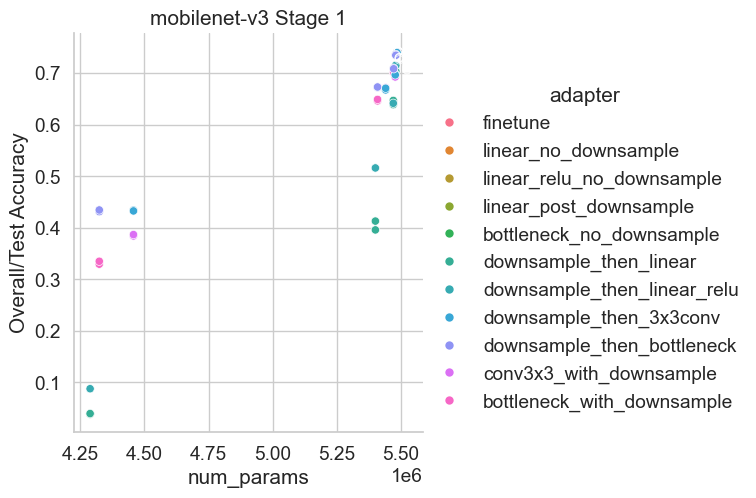

In [31]:
_ = plot_accuracy_vs_size(final_df, start_block=current_src_stage, arch_choice="mobilenet-v3")

Saving plot: ../experiments/across-scales/figures/mobilenet-v3-stage-1-acc-vs-flops.(pdf/png)


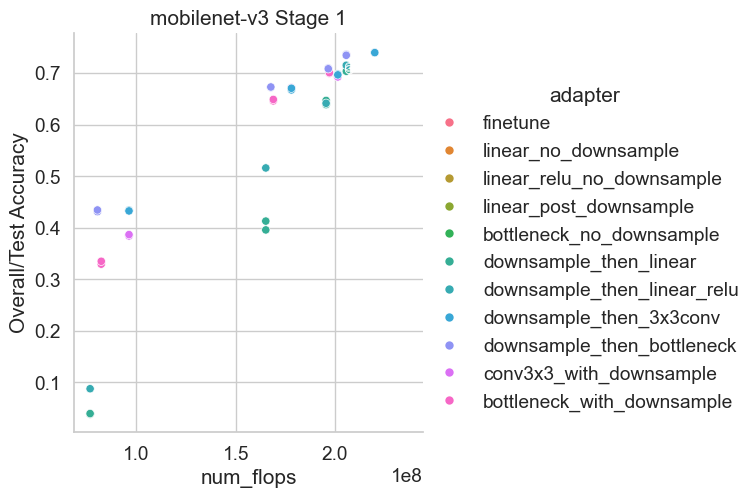

In [32]:
_ = plot_accuracy_vs_flops(final_df, start_block=current_src_stage, arch_choice="mobilenet-v3")

Saving plot: ../experiments/across-scales/figures/resnet-50-swin-t-stage-1-acc-vs-depth.(pdf/png)


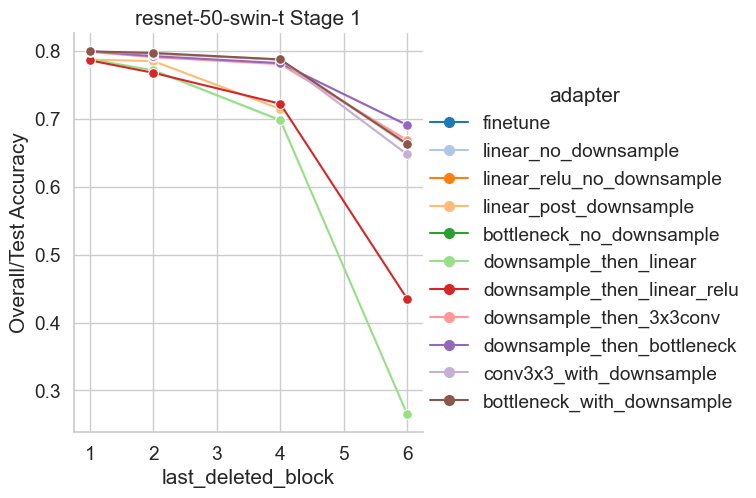

In [33]:
_ = plot_accuracy_vs_depth(final_df, start_block=current_src_stage, arch_choice="resnet-50-swin-t")

Saving plot: ../experiments/across-scales/figures/resnet-50-swin-t-stage-1-acc-vs-size.(pdf/png)


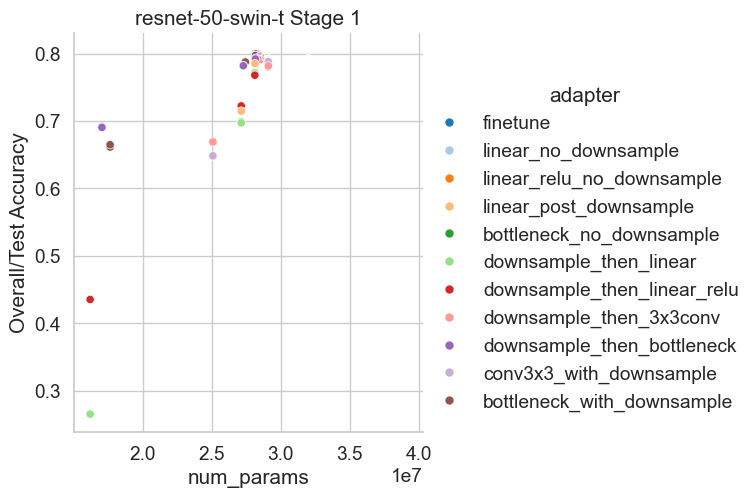

In [34]:
_ = plot_accuracy_vs_size(final_df, start_block=current_src_stage, arch_choice="resnet-50-swin-t")

Saving plot: ../experiments/across-scales/figures/resnet-50-swin-t-stage-1-acc-vs-flops.(pdf/png)


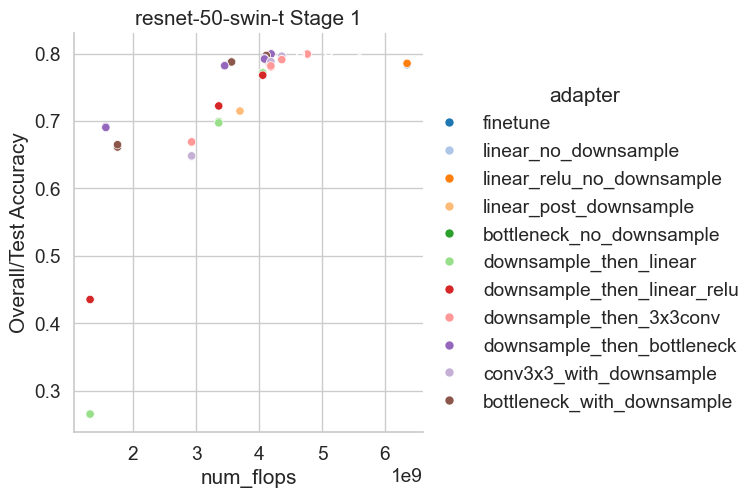

In [35]:
_ = plot_accuracy_vs_flops(final_df, start_block=current_src_stage, arch_choice="resnet-50-swin-t")

# Learning Rate Ablations

In [56]:
archname = "resnet-50"
lr_archs = [
    f"{archname}-lr-1.0e-2",
    f"{archname}",
    f"{archname}-lr-2.0e-4",
    #f"{archname}-lr-2.0e-4-wd-0.01",
]
wd_archs = [
    f"{archname}-wd-0.01",
    f"{archname}",
    f"{archname}-wd-0.3",
]
LR_ADAPTERS = [
    "bottleneck_with_downsample",
    "conv3x3_with_downsample",
    "downsample_then_bottleneck",
    "downsample_then_linear",
    "finetune"
]

Saving plot: ../experiments/across-scales/figures/resnet-50-lr-1.0e-2-stage-2-acc-vs-depth.(pdf/png)
Saving plot: ../experiments/across-scales/figures/resnet-50-stage-2-acc-vs-depth.(pdf/png)
Saving plot: ../experiments/across-scales/figures/resnet-50-lr-2.0e-4-stage-2-acc-vs-depth.(pdf/png)


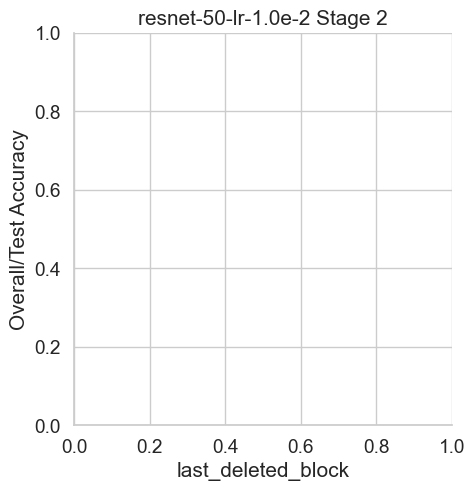

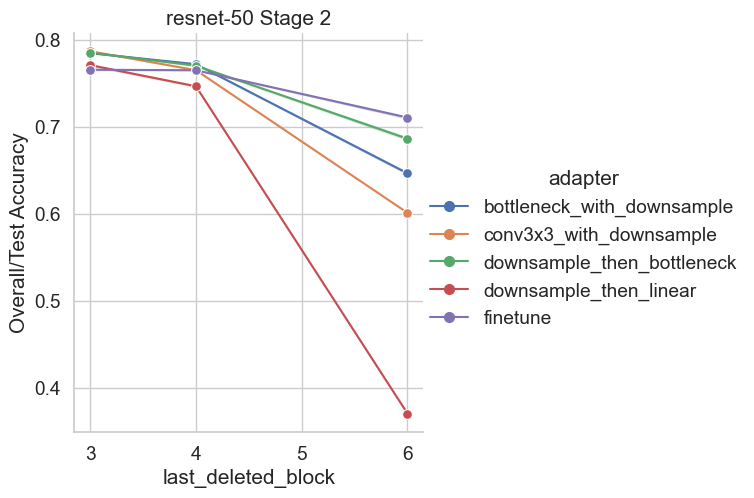

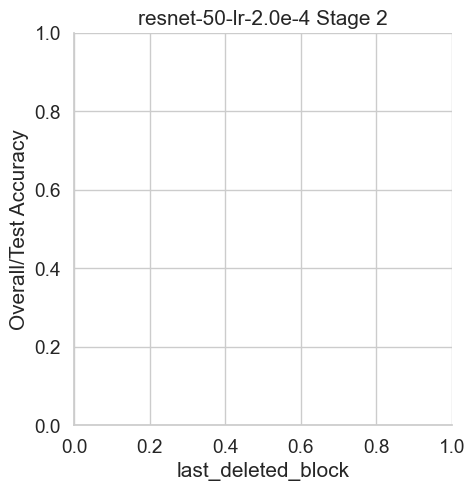

In [57]:
for arch in lr_archs:
    _ = plot_accuracy_vs_depth(final_df, start_block=current_src_stage, arch_choice=arch, adapter_choice=LR_ADAPTERS)

In [58]:
lr_rows = final_df.index.get_level_values("arch").str.fullmatch(f"{archname}(-lr.*)?")
resnet50_lr_archs = final_df.loc[lr_rows]
group_cols = list(set(resnet50_lr_archs.index.names) - {"seed", "Step", "arch"})
best_learning_rate = resnet50_lr_archs.groupby(group_cols)["Overall/Test Accuracy"].max().to_frame()
best_learning_rate = best_learning_rate.sort_values(["adapter", "first_deleted_block", "last_deleted_block"])

Saving plot: ../experiments/across-scales/figures/best-of-all-lrs---resnet-50-stage-2-acc-vs-depth.(pdf/png)


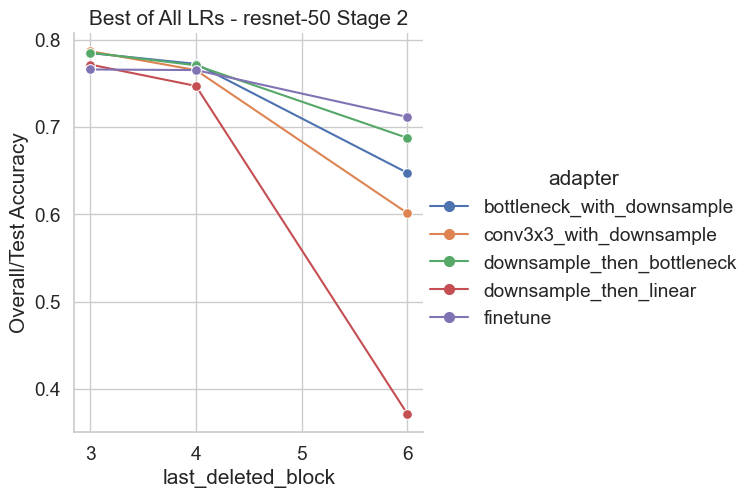

In [59]:
_ = plot_accuracy_vs_depth(best_learning_rate, start_block=current_src_stage, adapter_choice=LR_ADAPTERS,
                           name=f"Best of All LRs - {archname}")

Saving plot: ../experiments/across-scales/figures/different-lrs---resnet-50-stage-2-finetune-acc-vs-depth.(pdf/png)


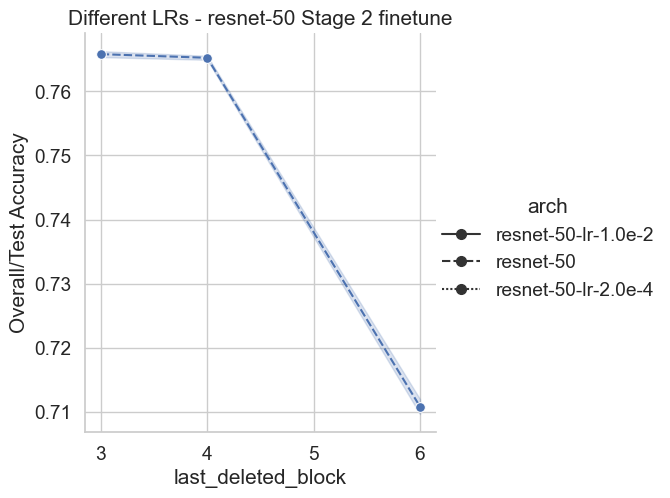

In [60]:
_ = plot_accuracy_vs_depth(final_df, start_block=current_src_stage, arch_choice=lr_archs, adapter_choice="finetune",
                           name=f"Different LRs - {archname}")

Saving plot: ../experiments/across-scales/figures/different-lrs---resnet-50-stage-2-bottleneck_with_downsample-acc-vs-depth.(pdf/png)


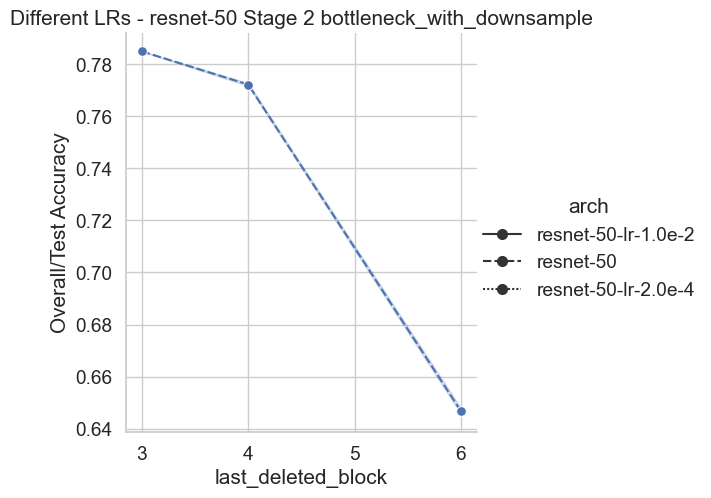

In [61]:
_ = plot_accuracy_vs_depth(final_df, start_block=current_src_stage, arch_choice=lr_archs,
                           adapter_choice="bottleneck_with_downsample", name=f"Different LRs - {archname}")

Saving plot: ../experiments/across-scales/figures/different-lrs---resnet-50-stage-2-downsample_then_bottleneck-acc-vs-depth.(pdf/png)


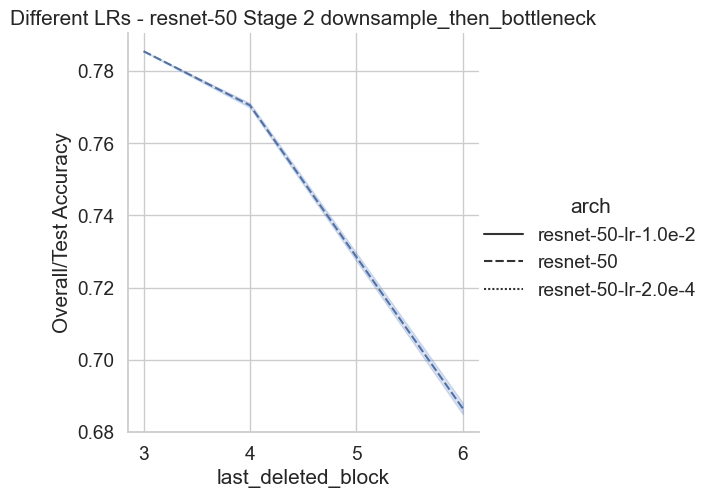

In [62]:
_ = plot_accuracy_vs_depth(final_df, start_block=current_src_stage, arch_choice=lr_archs,
                           adapter_choice="downsample_then_bottleneck", name=f"Different LRs - {archname}",
                           marker=None)

In [63]:
wd_rows = final_df.index.get_level_values("arch").str.fullmatch(f"{archname}(-wd.*)?")
resnet50_wd_archs = final_df.loc[wd_rows]
group_cols = list(set(resnet50_wd_archs.index.names) - {"seed", "Step", "arch"})
best_weight_decay = resnet50_wd_archs.groupby(group_cols)["Overall/Test Accuracy"].max().to_frame()
best_weight_decay = best_weight_decay.sort_values(["adapter", "first_deleted_block", "last_deleted_block"])

Saving plot: ../experiments/across-scales/figures/best-of-all-wds---resnet-50-stage-2-acc-vs-depth.(pdf/png)


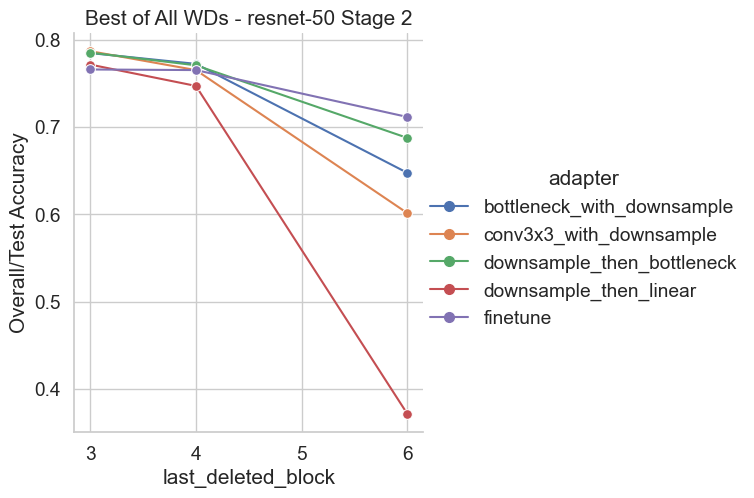

In [64]:
_ = plot_accuracy_vs_depth(best_weight_decay, start_block=current_src_stage, adapter_choice=LR_ADAPTERS,
                           name=f"Best of All WDs - {archname}")

Saving plot: ../experiments/across-scales/figures/different-wds---resnet-50-stage-2-finetune-acc-vs-depth.(pdf/png)


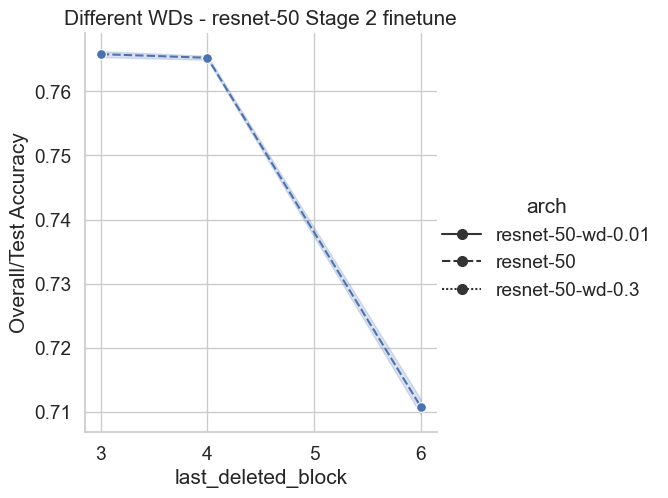

In [65]:
_ = plot_accuracy_vs_depth(final_df, start_block=current_src_stage, arch_choice=wd_archs, adapter_choice="finetune",
                           name=f"Different WDs - {archname}")

Saving plot: ../experiments/across-scales/figures/different-wds---resnet-50-stage-2-downsample_then_linear-acc-vs-depth.(pdf/png)


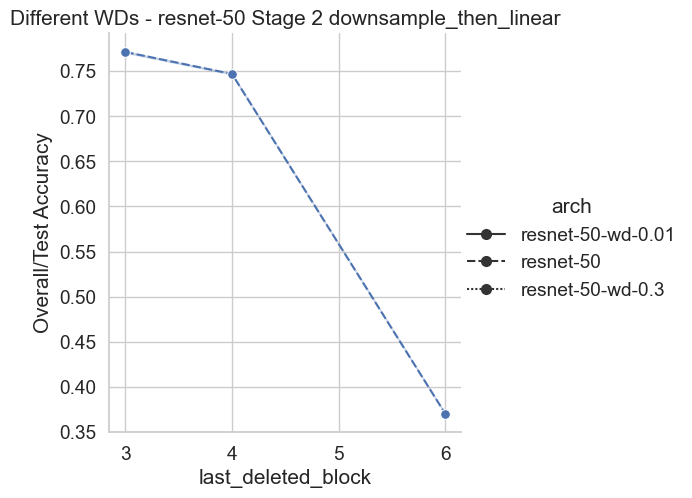

In [66]:
_ = plot_accuracy_vs_depth(final_df, start_block=current_src_stage, arch_choice=wd_archs,
                           adapter_choice="downsample_then_linear", name=f"Different WDs - {archname}")

# Sandbox

In [17]:
final_df.loc[final_df.index.get_level_values("arch") == "resnet-50"]

Step  \
adapter                    arch      first_deleted_block last_deleted_block num_downsamples num_params num_trainable_params seed  Step  Epoch          
block_with_downsample      resnet-50 1                   1                  0               26596904   1180672              12345 25030 10     25030   
                                                                                                                            67890 25030 10     25030   
bottleneck_with_downsample resnet-50 1                   1                  0               25486632   70400                12345 25030 10     25030   
                                                                                                                            67890 25030 10     25030   
conv3x3_with_downsample    resnet-50 1                   1                  0               26007336   591104               12345 25030 10     25030   
...                                                                                                                                              ...   
bottleneck_with_downsample resnet-50 3                   4                  1               24716840   1512448              12345 25030 10     25030   
conv3x3_with_downsample    resnet-50 3                   4                  1               27927080   4722688              12345 25030 10     25030   
downsample_then_3x3conv    resnet-50 3                   4                  1               27927080   4722688              12345 25030 10     25030   
downsample_then_bottleneck resnet-50 3                   4                  1               24716840   1512448              12345 25030 10     25030   
downsample_then_linear     resnet-50 3                   4                  1               23732776   528384               12345 25030 10     25030   

                                                                                                                                               Time/Data  \
adapter                    arch      first_deleted_block last_deleted_block num_downsamples num_params num_trainable_params seed  Step  Epoch              
block_with_downsample      resnet-50 1                   1                  0               26596904   1180672              12345 25030 10      0.000141   
                                                                                                                            67890 25030 10      0.000273   
bottleneck_with_downsample resnet-50 1                   1                  0               25486632   70400                12345 25030 10      0.000160   
                                                                                                                            67890 25030 10      0.000038   
conv3x3_with_downsample    resnet-50 1                   1                  0               26007336   591104               12345 25030 10      0.000188   
...                                                                                                                                                  ...   
bottleneck_with_downsample resnet-50 3                   4                  1               24716840   1512448              12345 25030 10      0.000086   
conv3x3_with_downsample    resnet-50 3                   4                  1               27927080   4722688              12345 25030 10      0.000129   
downsample_then_3x3conv    resnet-50 3                   4                  1               27927080   4722688              12345 25030 10      0.000131   
downsample_then_bottleneck resnet-50 3                   4                  1               24716840   1512448              12345 25030 10      0.000164   
downsample_then_linear     resnet-50 3                   4                  1               23732776   528384               12345 25030 10      0.000203   

                                                                                                                                          